In [27]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
import copy
import json
from utils import train # custom function to train the model

# For evaluation metrics
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)

In [2]:
# Check device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


<h1 style="color: orange;">Paths</h1>

In [3]:
current_path = os.getcwd()
current_path = os.path.dirname(current_path)
data_dir = os.path.join(current_path, "3-Train-Val-Test-Split")

<h1 style="color: orange;">Data Augmentation & Processing</h1>

In [4]:
input_size = 224 # ResNet50 expects 224x224 images

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),  # Random cropping and resizing
        transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
        transforms.RandomVerticalFlip(p=0.5),  # Flip images vertically with 50% probability (if plausible)
        transforms.RandomRotation(degrees=45),  # Rotate images randomly within ±45 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
        transforms.RandomAffine(
            degrees=15,  # Rotate within ±15 degrees
            translate=(0.1, 0.1),  # Allow small translations (10% of image size)
            scale=(0.9, 1.1),  # Allow small zoom in/out
            shear=10  # Allow small shearing
        ),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply slight blurring
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize for ResNet50
    ]),
    'val': transforms.Compose([
        transforms.Resize(int(input_size * 1.1)),  # Resize slightly larger to allow for CenterCrop
        transforms.CenterCrop(input_size),  # Crop to the target size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(int(input_size * 1.1)),  # Resize slightly larger to allow for CenterCrop
        transforms.CenterCrop(input_size),  # Crop to the target size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


<h1 style="color: orange;">Data Loading</h1>

In [5]:
image_datasets = {
    phase: datasets.ImageFolder(
        os.path.join(data_dir, phase), 
        transform=data_transforms[phase]
    )
    for phase in ['train', 'val', 'test']
}

In [6]:
# Create data loaders
batch_size = 64
dataloaders = {
    phase: DataLoader(
        image_datasets[phase], 
        batch_size=batch_size, 
        shuffle=True if phase == 'train' else False,
        num_workers=2
    )
    for phase in ['train', 'val', 'test']
}

In [7]:
# Dataset sizes and class names
dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)

Classes: ['asteroid', 'comet', 'galaxy', 'nebula', 'planet', 'star']
Dataset sizes: {'train': 1800, 'val': 600, 'test': 600}


<h1 style="color: orange;">Transfer Learning</h1>

In [9]:
model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

In [10]:
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Modify the final layer to match the number of classes
num_ftrs = model.fc.in_features
num_classes = len(class_names)  # Number of classes in your dataset
model.fc = nn.Linear(num_ftrs, num_classes)  # Fully connected layer
model = model.to(device) # Move model to device (GPU or CPU)

<h2 style="color: orange;">Hyperparameters</h2>

In [12]:
criterion = nn.CrossEntropyLoss() # Loss function
learning_rate = 1e-3 
epochs = 20
scheduler_step_size = 7
scheduler_gamma = 0.1
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate) # Optimizer
scheduler = lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

<h2 style="color: orange;">Training</h2>

In [13]:
model, history = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    num_epochs=20,
)

Epoch 1/20
----------
Train Loss: 1.6652 Acc: 0.3039
Val Loss: 1.5474 Acc: 0.3717
Epoch 2/20
----------
Train Loss: 1.5032 Acc: 0.3817
Val Loss: 1.5077 Acc: 0.3417
Epoch 3/20
----------
Train Loss: 1.4667 Acc: 0.4067
Val Loss: 1.4761 Acc: 0.3750
Epoch 4/20
----------
Train Loss: 1.4203 Acc: 0.4306
Val Loss: 1.4805 Acc: 0.3883
Epoch 5/20
----------
Train Loss: 1.3852 Acc: 0.4511
Val Loss: 1.4513 Acc: 0.4217
Epoch 6/20
----------
Train Loss: 1.3559 Acc: 0.4761
Val Loss: 1.4386 Acc: 0.4550
Epoch 7/20
----------
Train Loss: 1.3454 Acc: 0.4656
Val Loss: 1.4418 Acc: 0.4400
Epoch 8/20
----------
Train Loss: 1.3279 Acc: 0.4911
Val Loss: 1.4471 Acc: 0.4433
Epoch 9/20
----------
Train Loss: 1.3292 Acc: 0.4839
Val Loss: 1.4346 Acc: 0.4483
Early stopping triggered after 3 epochs without improvement.
Training complete


In [20]:
def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

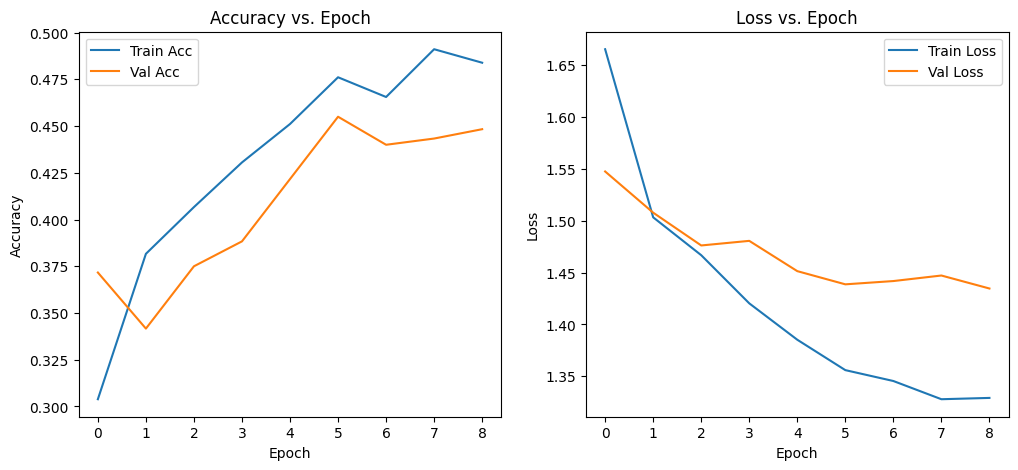

In [21]:
plot_history(history)

In [30]:
torch.save(model.state_dict(), "./Base-Model/best_model.pth")

In [31]:
# Save training history
with open('./Base-Model/model_history.json', 'w') as f:
    json.dump(history, f)

print("Training history saved to './Models/model_history.json'")

Training history saved to './Models/model_history.json'
